## 第四組第一次讀書會作業 
組長：張恩綮

組員：陳亭瑄、吳信輝、蕭宇廷、林晏甄、陳學蒨

#### 大綱
1. 專案動機與資料介紹
2. 軟體工作文字雲
3. lexicon-base情緒分析
4. CKIP自然語言處理


## 1. 專案動機與資料介紹

- 動機：我們想了解畢業之後若想進入軟體領域工作有哪些該注意的地方，以了解現階段可以努力和思考的方向。

資料來源：
+ Tarflow爬取PPT Soft_Job板資料
+ 關鍵字：公司、面試、工作、能力、經驗、時間、程式
+ 時間： 2022-01-01 ~ 2024-12-31
+ 資料筆數：共 2269 篇文章

In [1]:
# 載入套件
import pandas as pd
import os
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
%matplotlib inline

from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import time
import datetime

In [2]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

# 設定文字雲中文字體路徑
FontPath = 'SourceHanSansTW-Regular.otf' # 設定字型

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 120

合併2022、2023、2024的資料

In [3]:
print("當前工作目錄:", os.getcwd()) 
# 設定要合併的 CSV 檔案
csv_files = ["2022.csv", "2023.csv", "2024.csv"]

# 創建一個空的 DataFrame 來存放合併的資料
merged_df = pd.DataFrame()

# 逐個讀取 CSV 並合併
for file in csv_files:
    if os.path.exists(file):  # 確保檔案存在
        df = pd.read_csv(file)  # 讀取 CSV
        merged_df = pd.concat([merged_df, df], ignore_index=True)  # 合併
    else:
        print(f"⚠ 檔案 {file} 不存在，請檢查路徑")

# 儲存合併後的 CSV
merged_df.to_csv("merge.csv", index=False, encoding="utf-8-sig")  # 確保支援中文

print("✅ CSV 檔案合併完成！存成 merge.csv")
import os
print("當前工作目錄:", os.getcwd())  # 檢查當前的工作路徑
print("資料夾內的檔案:", os.listdir())  # 顯示當前資料夾的所有檔案


當前工作目錄: c:\第一次作業
✅ CSV 檔案合併完成！存成 merge.csv
當前工作目錄: c:\第一次作業
資料夾內的檔案: ['2022.csv', '2023.csv', '2024.csv', 'clean_merge.csv', 'data', 'data.zip', 'dict.txt', 'entity_table_softjob.csv', 'first.ipynb', 'LIWC_CH.csv', 'LIWC_EN.csv', 'merge.csv', 'negative.txt', 'positive.txt', 'pos_table_softjob.csv', 'sentence_table_softjob.csv', 'SourceHanSansTW-Regular.otf', 'stopwords.txt', 'TaipeiSansTCBeta-Regular.ttf', 'user_dict.txt']


In [4]:
#讀入資料集
df = pd.read_csv('merge.csv')
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...   
3          4  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...   
4          5  https://www.ptt.cc/bbs/Soft_Job/M.1641095795.A...   

                        artTitle              artDate     artPoster  \
0            Re:[請益]刷leetcode找工作  2022-01-01 01:21:54     Ericz7000   
1           [請益]請問面試作品可以放gitlab嗎  2022-01-01 14:13:40      s9503669   
2            Re:[請益]刷leetcode找工作  2022-01-01 14:59:51  FlowerKnight   
3                [請益]金融業是不是最慘的產業  2022-01-02 00:08:55      a3300552   
4  Re:[請益]以java作為技能的最低入行門檻(更新回應)  2022-01-02 11:56:32         qrtt1   

  artCatagory                                         artContent  \
0    Soft_Job  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1    Soft_Job  不好意思，因為不是很確定所以想問一下，\n\n\n通常很多職缺都會要求求職者給 github...   
2    Soft_Job  在下的觀察\n\n找工作分成履歷跟面試 履歷關過了才有面試\n\n大概會看這些\n\n* 資...   
3    Soft_Job  小弟在金融業當工程師\n\n底薪目前看來身邊同學每個都是7~9萬\n\n目前還在領5萬多\n...   
4    Soft_Job  :\n:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n[---]\n\n  其實...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "chocopie", "...     216.9.110.8   
1  [{"cmtStatus": "→", "cmtPoster": "gasbomb", "c...    1.200.71.248   
2  [{"cmtStatus": "推", "cmtPoster": "SouthRa", "c...  125.228.129.84   
3  [{"cmtStatus": "→", "cmtPoster": "viper9709", ...  180.176.11.213   
4  [{"cmtStatus": "推", "cmtPoster": "alberty0519"...   36.227.43.158   

          insertedDate dataSource  
0  2022-01-02 01:14:39        ptt  
1  2022-01-02 01:14:39        ptt  
2  2022-01-02 01:14:39        ptt  
3  2022-01-02 01:14:39        ptt  
4  2022-01-03 01:11:59        ptt

## 2. 軟體工作文字雲
### 2.1 資料前處理
- 清除內文為空值的文章

- 將兩個換行取代為句號

- 清除不重要的字如換行、網址

In [5]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

# 轉換 artDate 只保留日期部分（去掉時間）
clear_df['artDate'] = pd.to_datetime(clear_df['artDate']).dt.date

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...   
1  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...   
2  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...   
3  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...   
4  https://www.ptt.cc/bbs/Soft_Job/M.1641095795.A...   
5  https://www.ptt.cc/bbs/Soft_Job/M.1641170715.A...   
6  https://www.ptt.cc/bbs/Soft_Job/M.1641184780.A...   
7  https://www.ptt.cc/bbs/Soft_Job/M.1641217344.A...   
8  https://www.ptt.cc/bbs/Soft_Job/M.1641279358.A...   
9  https://www.ptt.cc/bbs/Soft_Job/M.1641293806.A...   

                           artTitle     artDate  \
0               Re:[請益]刷leetcode找工作  2022-01-01   
1              [請益]請問面試作品可以放gitlab嗎  2022-01-01   
2               Re:[請益]刷leetcode找工作  2022-01-01   
3                   [請益]金融業是不是最慘的產業  2022-01-02   
4     Re:[請益]以java作為技能的最低入行門檻(更新回應)  2022-01-02   
5          開店123徵PHP工程師(50k~80k/1Y)  2022-01-03   
6            [徵才]五倍紅寶石程式教育機構徵前後端工程師  2022-01-03   
7                    [請益]Offer/現職請益  2022-01-03   
8       Re:[討論]FBTaiwanBackendGroup  2022-01-04   
9  [徵才]TrapaSecurity徵研發工程師(50k~72K)  2022-01-04   

                                          artContent  \
0  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1  不好意思，因為不是很確定所以想問一下，\n\n\n通常很多職缺都會要求求職者給 github...   
2  在下的觀察\n\n找工作分成履歷跟面試 履歷關過了才有面試\n\n大概會看這些\n\n* 資...   
3  小弟在金融業當工程師\n\n底薪目前看來身邊同學每個都是7~9萬\n\n目前還在領5萬多\n...   
4  :\n:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n[---]\n\n  其實...   
5  公司名稱和統編：\n\n開店一二三網路科技股份有限公司\n\n54652437\n\n\n\...   
6  公司名稱，統編(中華民國以外註冊可免填):\n五倍紅寶石專業程式教育機構 統編：881171...   
7  (非本人，純代PO)\n\n各位好，小弟約4-5年iOS經驗\n最近剛取得一份新的offer...   
8  https://imgur.com/a/DtyZQGk\n一轉眼也是過了兩年，當回顧這些年做...   
9  公司名稱，統編:\nTrapaSecurity 菱鏡股份有限公司 (統編:83750577)...   

                                            sentence  
0  哥。一兩個月前剛剛找完工作。有個心得。我覺得啦。用Leetcode面試。就只是個媒介。題目通...  
1  不好意思，因為不是很確定所以想問一下，。，通常很多職缺都會要求求職者給 github 作品連...  
2  在下的觀察。找工作分成履歷跟面試 履歷關過了才有面試。大概會看這些。* 資深，履歷: 不分產...  
3  小弟在金融業當工程師。底薪目前看來身邊同學每個都是7~9萬。目前還在領5萬多。年終更是被屌打...  
4  :，:，:，:，:，:，:，:，:，:，:，[---]。  其實只要幫忙分一下類別，就不會覺...  
5  公司名稱和統編：。開店一二三網路科技股份有限公司。54652437。。公司地址：。台北市大安...  
6  公司名稱，統編(中華民國以外註冊可免填):，五倍紅寶石專業程式教育機構 統編：8811712...  
7  (非本人，純代PO)。各位好，小弟約4-5年iOS經驗，最近剛取得一份新的offer，請教大...  
8   好像前面做的事，都有為了之後做準備的感覺，剛好接上。 兩年前其實那時候我也沒有多資深，年資...  
9  公司名稱，統編:，TrapaSecurity 菱鏡股份有限公司 (統編:83750577)。...

### 2.2 斷句 

In [6]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
3  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
5  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
6  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
7  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
8  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
9  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   

      artDate                                         artContent  \
0  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
3  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
4  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
5  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
6  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
7  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
8  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
9  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   

          sentence  
0                哥  
1      一兩個月前剛剛找完工作  
2             有個心得  
3             我覺得啦  
4      用Leetcode面試  
5           就只是個媒介  
6           題目通常不難  
7           解出來是基本  
8      主要是想測試一下你各位  
9  講解你的想法的時候思路清不清晰

### 2.3 斷詞

In [7]:
jieba.set_dictionary('dict.txt')

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

artUrl             artTitle  \
1   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
3   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
5   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
6   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
7   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
8   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
9   https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
10  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   

       artDate                                         artContent  \
1   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
2   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
3   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
4   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
5   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
6   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
7   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
8   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
9   2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
10  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   

           sentence  
1       一兩個月前剛剛找完工作  
2              有個心得  
3              我覺得啦  
4       用Leetcode面試  
5            就只是個媒介  
6            題目通常不難  
7            解出來是基本  
8       主要是想測試一下你各位  
9   講解你的想法的時候思路清不清晰  
10         有基本的溝通能力

In [8]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

# 去除空值
word_df = word_df.dropna(subset=['word'])

#word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

Building prefix dict from c:\第一次作業\dict.txt ...
Dumping model to file cache C:\Users\angel\AppData\Local\Temp\jieba.u544c068219885a0dcf2459a342782b4e.cache
Loading model cost 0.669 seconds.
Prefix dict has been built successfully.


artUrl             artTitle  \
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
3  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   

      artDate                                         artContent word  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...  一兩個  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...    月  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...    前  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   剛剛  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...    找  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...    完  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   工作  
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   有個  
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   心得  
3  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...    我

### 2.4 計算去除停用字及更新字典前的詞頻並視覺化結果

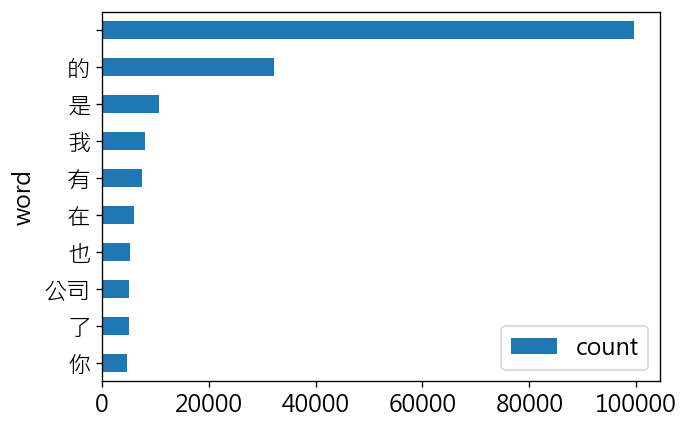

In [9]:
freq_df = word_df['word'].value_counts().reset_index()
freq_df.columns = ['word', 'count']  # 重新命名欄位
freq_df = freq_df.sort_values(by=['count'], ascending=False)
freq_df.head(10)

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()


In [10]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

print(dict(list(freq_dict.items())[:10]))

{' ': 99516, '的': 32169, '是': 10683, '我': 8002, '有': 7502, '在': 5979, '也': 5285, '公司': 5105, '了': 5087, '你': 4595}


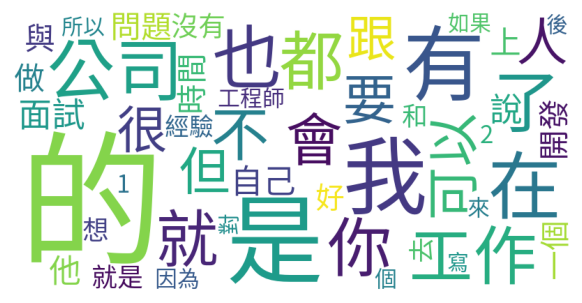

In [11]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (6,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [12]:
#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

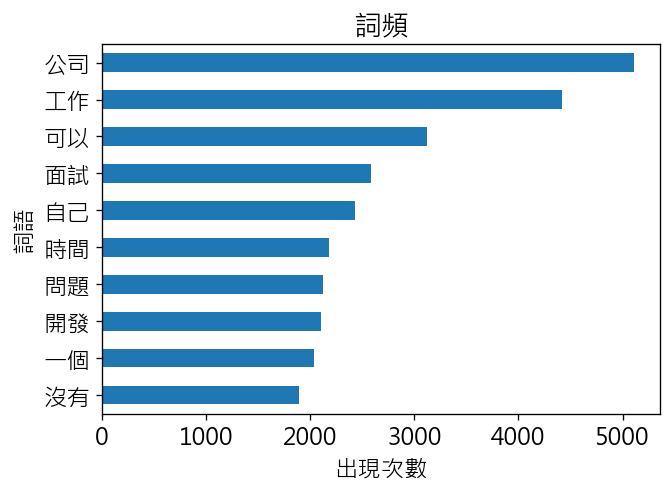

In [13]:
# 產生詞頻 DataFrame
freq_df = word_df['word'].value_counts().reset_index()
freq_df.columns = ['word', 'count']
freq_df = freq_df.sort_values(by=['count'], ascending=False)  

# 繪製長條圖
ax = freq_df.head(10).plot.barh(x='word', y='count', legend=False)
ax.invert_yaxis()  # 高first
plt.xlabel("出現次數")
plt.ylabel("詞語")
plt.title("詞頻")
plt.show()


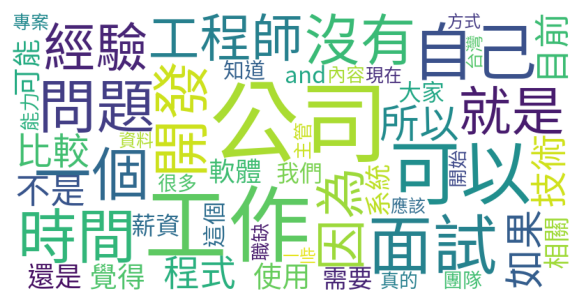

In [14]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_no1 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_no1.generate_from_frequencies(freq_dict)

plt.figure(figsize = (6,4))
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.show()

### 2.5 移除停用字

In [15]:
stopwords = [line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').readlines()] 

In [16]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

artUrl             artTitle  \
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
5  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
6  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
6  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   

      artDate                                         artContent      word  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...       一兩個  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        剛剛  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        工作  
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        有個  
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        心得  
4  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...  Leetcode  
4  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        面試  
5  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        媒介  
6  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        題目  
6  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        通常

計算詞頻並繪製長條圖

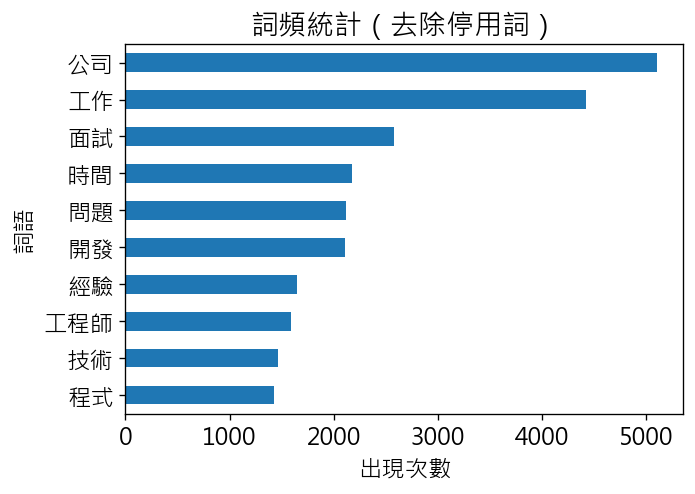

In [17]:
# 產生詞頻 DataFrame
freq_df_nostop = noStop_df['word'].value_counts().reset_index()
freq_df_nostop.columns = ['word', 'count']  # 設定正確的欄位名稱
freq_df_nostop = freq_df_nostop.sort_values(by=['count'], ascending=False)  # 按次數排序

# 繪製水平長條圖
ax = freq_df_nostop.head(10).plot.barh(x='word', y='count', legend=False)
ax.invert_yaxis()  # 讓最高頻詞排在最上方
plt.xlabel("出現次數")
plt.ylabel("詞語")
plt.title("詞頻統計（去除停用詞）")
plt.show()

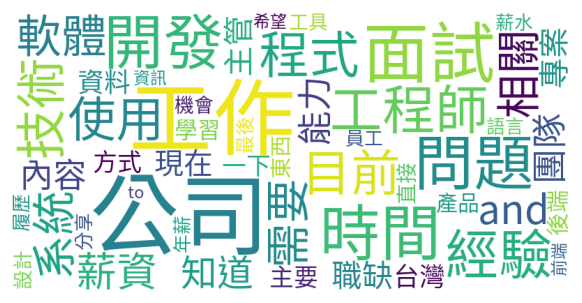

In [18]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (6,4))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

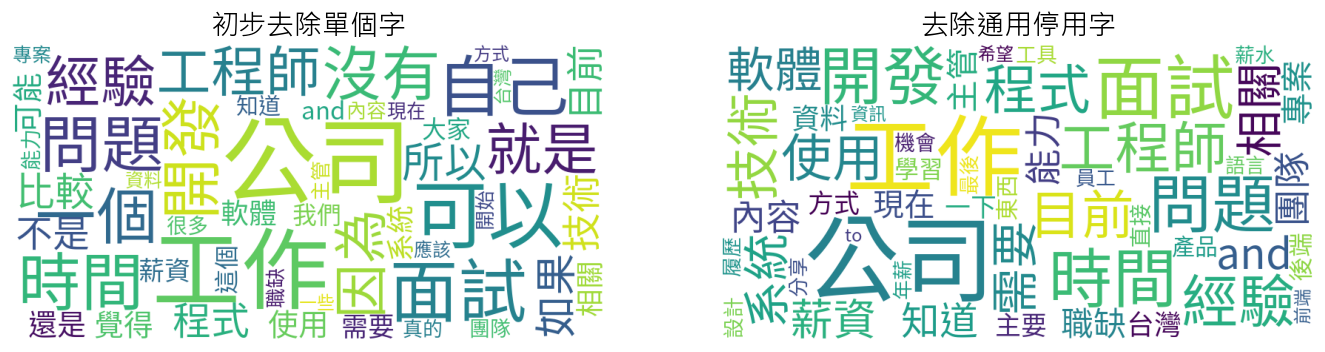

In [19]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

### 2.6 更新停用字字典

In [20]:
# 參數形式手動加入停用字
stopwords_manual = ["需要", "to", "and", "最後", "現在", "直接", "因為", "大概", "目前", "知道", "還是", "沒有", "什麼", "這個", "時候", "一下", "真的", "開始", "我們", "一個", "這些", "可能"]
stopwords.extend(stopwords_manual)

In [21]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

artUrl             artTitle  \
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
5  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
6  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
6  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   

      artDate                                         artContent      word  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...       一兩個  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        剛剛  
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        工作  
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        有個  
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        心得  
4  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...  Leetcode  
4  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        面試  
5  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        媒介  
6  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        題目  
6  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...        通常

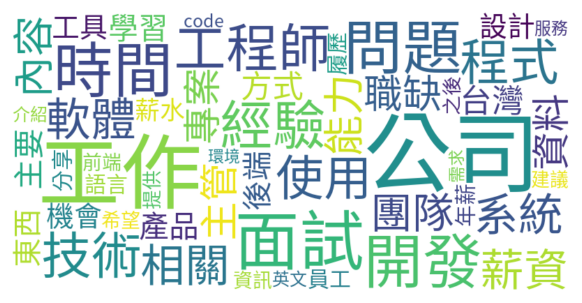

In [22]:
# 計算詞頻
freq_df_nostop_2 = noStop_df_2['word'].value_counts().reset_index()
freq_df_nostop_2.columns = ['word', 'count']  # 設定正確的欄位名稱
freq_df_nostop_2 = freq_df_nostop_2.sort_values(by=['count'], ascending=False)  # 重新排序

# wordcloud 的輸入須為 dict，因此轉換 freq_df
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word')['count'].to_dict()

# 繪製文字雲
wordcloud_nostop_2 = WordCloud(
    background_color='white',
    width=800,
    height=400,
    font_path=FontPath,
    max_words=50
).generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize=(6,4))
plt.imshow(wordcloud_nostop_2, interpolation='bilinear')
plt.axis('off')
plt.show()

最後將不同階段文字雲放在一起比較

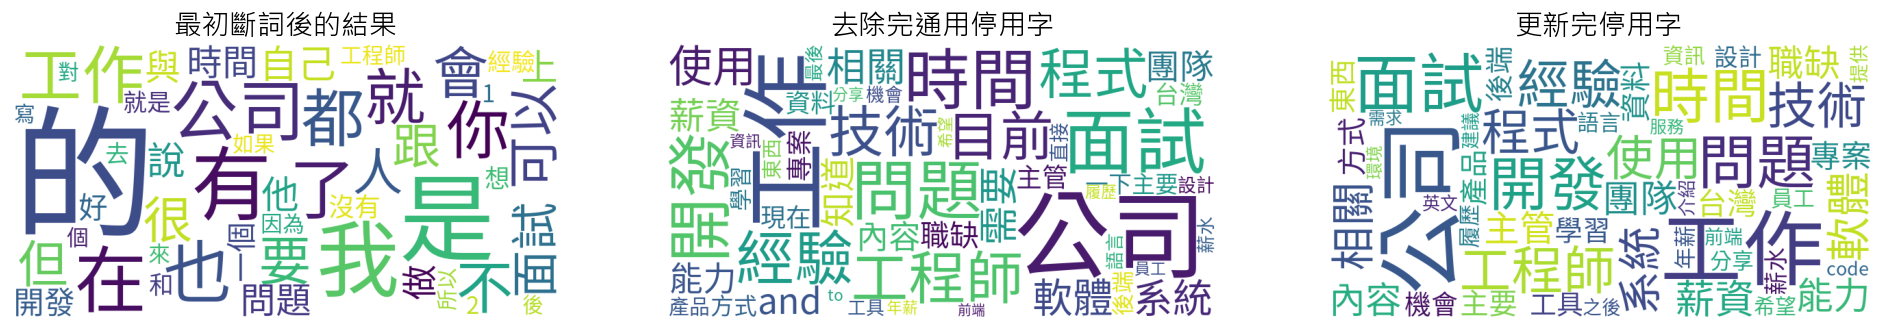

In [25]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

可以發現「開發」、「技術」、「薪資」也是有一定的討論度

## 3. lexicon-base情緒分析

In [23]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")

### 3.1 準備LIWC字典  

In [24]:
# 讀取情緒字典
liwc_dict = pd.read_csv("LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

### 3.2 情緒字典與斷詞結果進行合併

In [25]:
ptt_liwc_df = pd.merge(noStop_df_2, liwc_dict, how="left")
ptt_liwc_df.head()


artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
3  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   

      artDate                                         artContent word  \
0  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...  一兩個   
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   剛剛   
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   工作   
3  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   有個   
4  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   心得   

  sentiments  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

### 3.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [26]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count.head(10)

artDate sentiments  size
1   2022-01-01   negative     5
2   2022-01-01   positive    12
6   2022-01-02   negative    12
7   2022-01-02   positive    26
11  2022-01-03   negative     7
12  2022-01-03   positive    53
15  2022-01-04   negative     7
16  2022-01-04   positive    18
19  2022-01-05   negative     5
20  2022-01-05   positive    26

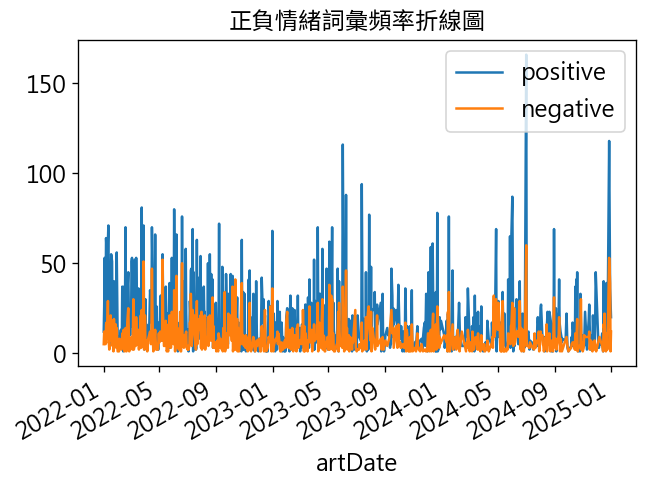

In [27]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop) 
plt.show()

大多數正面文章樹大於負面文章數

接下來繪製正負情緒詞彙頻率折線圖

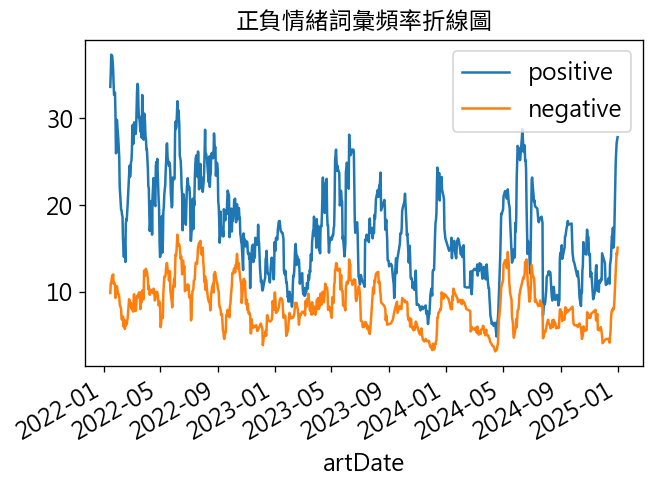

In [28]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

### 3.4 正負向情緒詞彙比例折線圖圖

In [29]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

artDate sentiments  size     ratio
1   2022-01-01   negative     5  0.294118
2   2022-01-01   positive    12  0.705882
6   2022-01-02   negative    12  0.315789
7   2022-01-02   positive    26  0.684211
11  2022-01-03   negative     7  0.116667
12  2022-01-03   positive    53  0.883333
15  2022-01-04   negative     7  0.280000
16  2022-01-04   positive    18  0.720000
19  2022-01-05   negative     5  0.161290
20  2022-01-05   positive    26  0.838710

In [30]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

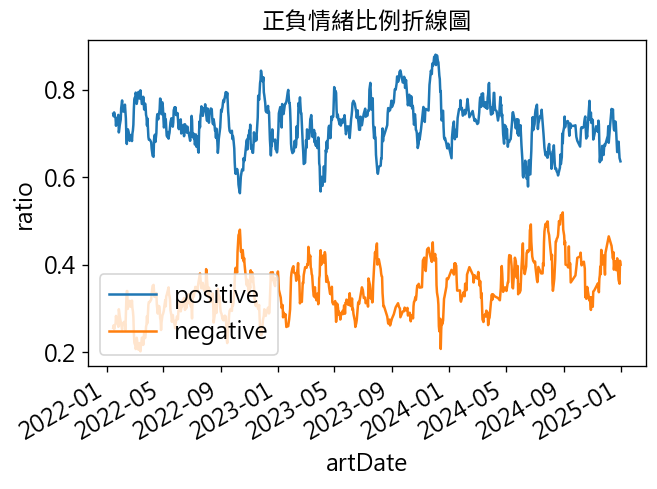

In [31]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 3.5 正負向情緒分數折線圖

In [32]:
sentiment_count.head(10)

artDate sentiments  size     ratio
1   2022-01-01   negative     5  0.294118
2   2022-01-01   positive    12  0.705882
6   2022-01-02   negative    12  0.315789
7   2022-01-02   positive    26  0.684211
11  2022-01-03   negative     7  0.116667
12  2022-01-03   positive    53  0.883333
15  2022-01-04   negative     7  0.280000
16  2022-01-04   positive    18  0.720000
19  2022-01-05   negative     5  0.161290
20  2022-01-05   positive    26  0.838710

In [33]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

artDate  negative  positive
0  2022-01-01       5.0      12.0
1  2022-01-02      12.0      26.0
2  2022-01-03       7.0      53.0
3  2022-01-04       7.0      18.0
4  2022-01-05       5.0      26.0

In [34]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2022-01-01       5.0      12.0              7.0
1  2022-01-02      12.0      26.0             14.0
2  2022-01-03       7.0      53.0             46.0
3  2022-01-04       7.0      18.0             11.0
4  2022-01-05       5.0      26.0             21.0

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

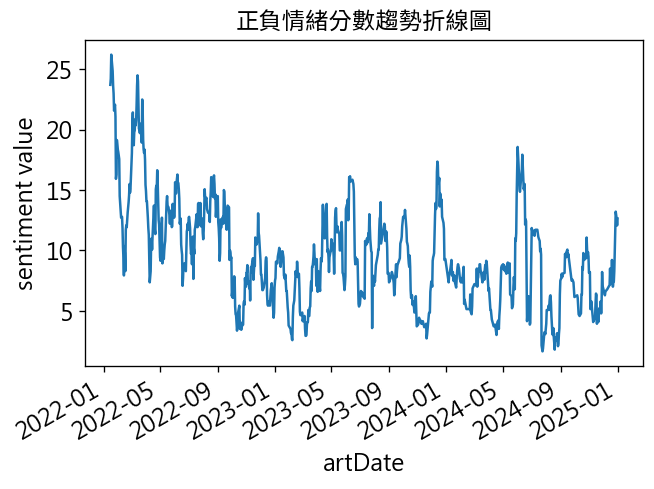

In [35]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.6 文章為單位的情緒分析

In [36]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

artUrl sentiments  size
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...     affect     1
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...   positive     1
2  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...     affect     5
3  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...   negative     1
4  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...   positive     4
5  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...     affect    16
6  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...   negative     4
7  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...   positive     7
8  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...     affect     4
9  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...        anx     1

In [37]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...     1.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...     5.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...    16.0    0.0  0.0   
3  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...     4.0    0.0  1.0   
4  https://www.ptt.cc/bbs/Soft_Job/M.1641095795.A...    35.0    4.0  1.0   

   negative  positive  sad  
0       0.0       1.0  0.0  
1       1.0       4.0  0.0  
2       4.0       7.0  0.0  
3       1.0       2.0  1.0  
4      11.0      24.0  0.0

計算文章情緒分數

In [38]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...     1.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...     5.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...    16.0    0.0  0.0   
3  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...     4.0    0.0  1.0   
4  https://www.ptt.cc/bbs/Soft_Job/M.1641095795.A...    35.0    4.0  1.0   

   negative  positive  sad  sentiment_value  
0       0.0       1.0  0.0              1.0  
1       1.0       4.0  0.0              3.0  
2       4.0       7.0  0.0              3.0  
3       1.0       2.0  1.0              1.0  
4      11.0      24.0  0.0             13.0

判斷各文章是正向還是負向

In [39]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...     1.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...     5.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...    16.0    0.0  0.0   
3  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...     4.0    0.0  1.0   
4  https://www.ptt.cc/bbs/Soft_Job/M.1641095795.A...    35.0    4.0  1.0   
5  https://www.ptt.cc/bbs/Soft_Job/M.1641170715.A...    23.0    0.0  0.0   
6  https://www.ptt.cc/bbs/Soft_Job/M.1641184780.A...    30.0    0.0  1.0   
7  https://www.ptt.cc/bbs/Soft_Job/M.1641217344.A...    12.0    0.0  1.0   
8  https://www.ptt.cc/bbs/Soft_Job/M.1641279358.A...     9.0    0.0  0.0   
9  https://www.ptt.cc/bbs/Soft_Job/M.1641293806.A...    21.0    2.0  0.0   

   negative  positive  sad  sentiment_value sentiment_class  
0       0.0       1.0  0.0              1.0              正向  
1       1.0       4.0  0.0              3.0              正向  
2       4.0       7.0  0.0              3.0              正向  
3       1.0       2.0  1.0              1.0              正向  
4      11.0      24.0  0.0             13.0              正向  
5       0.0      20.0  0.0             20.0              正向  
6       4.0      24.0  0.0             20.0              正向  
7       3.0       9.0  0.0              6.0              正向  
8       2.0       6.0  0.0              4.0              正向  
9       5.0      12.0  0.0              7.0              正向

In [41]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

clear_df_sentiment.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...   
3          4  https://www.ptt.cc/bbs/Soft_Job/M.1641053337.A...   
4          5  https://www.ptt.cc/bbs/Soft_Job/M.1641095795.A...   

                        artTitle     artDate     artPoster artCatagory  \
0            Re:[請益]刷leetcode找工作  2022-01-01     Ericz7000    Soft_Job   
1           [請益]請問面試作品可以放gitlab嗎  2022-01-01      s9503669    Soft_Job   
2            Re:[請益]刷leetcode找工作  2022-01-01  FlowerKnight    Soft_Job   
3                [請益]金融業是不是最慘的產業  2022-01-02      a3300552    Soft_Job   
4  Re:[請益]以java作為技能的最低入行門檻(更新回應)  2022-01-02         qrtt1    Soft_Job   

                                          artContent  \
0  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1  不好意思，因為不是很確定所以想問一下，\n\n\n通常很多職缺都會要求求職者給 github...   
2  在下的觀察\n\n找工作分成履歷跟面試 履歷關過了才有面試\n\n大概會看這些\n\n* 資...   
3  小弟在金融業當工程師\n\n底薪目前看來身邊同學每個都是7~9萬\n\n目前還在領5萬多\n...   
4  :\n:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n[---]\n\n  其實...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "chocopie", "...     216.9.110.8   
1  [{"cmtStatus": "→", "cmtPoster": "gasbomb", "c...    1.200.71.248   
2  [{"cmtStatus": "推", "cmtPoster": "SouthRa", "c...  125.228.129.84   
3  [{"cmtStatus": "→", "cmtPoster": "viper9709", ...  180.176.11.213   
4  [{"cmtStatus": "推", "cmtPoster": "alberty0519"...   36.227.43.158   

          insertedDate dataSource sentiment_class  
0  2022-01-02 01:14:39        ptt              正向  
1  2022-01-02 01:14:39        ptt              正向  
2  2022-01-02 01:14:39        ptt              正向  
3  2022-01-02 01:14:39        ptt              正向  
4  2022-01-03 01:11:59        ptt              正向

In [42]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

artDate sentiment_class  size
0     2022-01-01              正向     3
1     2022-01-02              正向     2
2     2022-01-03              正向     3
3     2022-01-04              正向     2
4     2022-01-05              正向     2
...          ...             ...   ...
1157  2024-12-29              正向     1
1158  2024-12-29              負向     1
1159  2024-12-30              負向     1
1160  2024-12-31              正向     1
1161  2024-12-31              負向     1

[1162 rows x 3 columns]

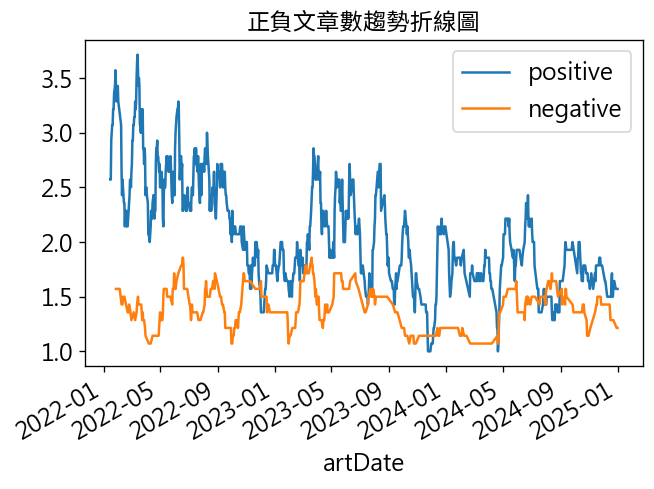

In [43]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

### 3.7 情緒代表字

In [44]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

word sentiments  size
411    問題   negative  2121
410    問題     affect  2121
232    分享     affect   666
233    分享   positive   666
646    希望     affect   641
647    希望   positive   641
1697   興趣     affect   514
1698   興趣   positive   514
1401   獎金     affect   489
1402   獎金   positive   489

In [45]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
233    分享   positive   666
647    希望   positive   641
1698   興趣   positive   514
1402   獎金   positive   489
1571   簡單   positive   445
1771   解決   positive   442
1111   朋友   positive   410
1819   謝謝   positive   397
1929   重要   positive   391
1538   福利   positive   371
835    感謝   positive   308
78     不錯   positive   304
1155   歡迎   positive   296
649    幫助   positive   295
423    喜歡   positive   274

In [46]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
411    問題   negative  2121
1680   自我   negative   180
485    壓力   negative   166
1622   缺點   negative   154
1021   擔心   negative   125
2057   麻煩   negative   116
462    困難   negative   105
1934   錯誤   negative   101
72     不足   negative    98
2017   風險   negative    89
1975   隨便   negative    77
984    控制   negative    77
952    拒絕   negative    76
1048   放棄   negative    70
523    失敗   negative    68

C:\Users\angel\AppData\Local\Temp\ipykernel_40248\1658640999.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\angel\AppData\Local\Temp\ipykernel_40248\1658640999.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


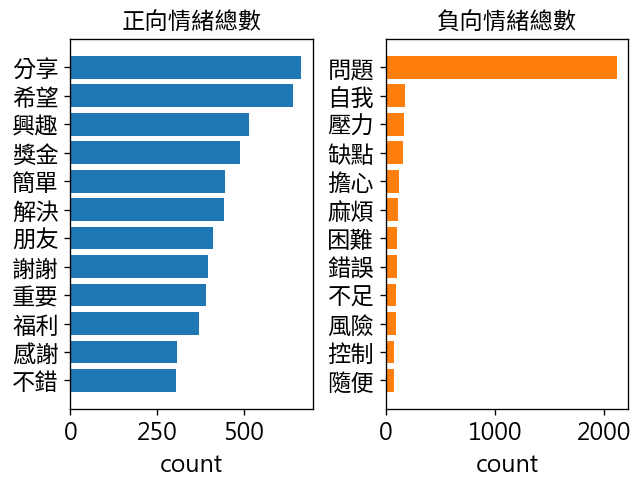

In [47]:
pos = word_of_pos.head(12).sort_values(["size"], ascending=True)
neg = word_of_neg.head(12).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

plt.subplots_adjust(wspace=0.3) 

#### 檢查情緒詞是否符合本文本

自我不一定代表自我中心，這類的負向情緒

In [48]:
filtered_df = sent_df[sent_df['sentence'].str.contains('自我', na=False)]
filtered_df.head()

artUrl             artTitle  \
2867  https://www.ptt.cc/bbs/Soft_Job/M.1642155731.A...    [心得]昕力(新竹辦公室)面試心得   
2869  https://www.ptt.cc/bbs/Soft_Job/M.1642155731.A...    [心得]昕力(新竹辦公室)面試心得   
3404  https://www.ptt.cc/bbs/Soft_Job/M.1642347072.A...  [請益]資策會JAVA班出來的發展進修   
3407  https://www.ptt.cc/bbs/Soft_Job/M.1642347072.A...  [請益]資策會JAVA班出來的發展進修   
3837  https://www.ptt.cc/bbs/Soft_Job/M.1642522974.A...     [心得]數學＆統計新鮮人面試分享   

         artDate                                         artContent  \
2867  2022-01-14  版上昕力資訊的相關文章有點少  想說來貢獻一下\n\n我是2021年5月中面試的  面試的部...   
2869  2022-01-14  版上昕力資訊的相關文章有點少  想說來貢獻一下\n\n我是2021年5月中面試的  面試的部...   
3404  2022-01-16  大家好，以下是幫我朋友詢問的問題，感謝!\n\n我非本科系大學畢業 從資策會Java班(目前...   
3407  2022-01-16  大家好，以下是幫我朋友詢問的問題，感謝!\n\n我非本科系大學畢業 從資策會Java班(目前...   
3837  2022-01-19  版上很少看到數學、統計背景的心得文，因此決定把我的經驗分享給以後的學弟妹。準備\n找工作時我...   

                             sentence  
2867         她先自我介紹了一下  並說明該部門PM要做的事情  
2869  輪到我則是自我介紹了一下  並說明過去PM的經歷跟做事情的方式  
3404                      自我學習的動力也很重要  
3407                有時會自我懷疑是否需辭掉工作去進修  
3837                          一開始自我介紹

In [49]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

她先自我介紹了一下  並說明該部門PM要做的事情
輪到我則是自我介紹了一下  並說明過去PM的經歷跟做事情的方式
 自我學習的動力也很重要
 有時會自我懷疑是否需辭掉工作去進修
    一開始自我介紹
    自我介紹
一開始先自我介紹
在只準備了自我介紹的情況下
也會在後續提薪資的時候產生自我懷疑
我自我介紹工作內容做過的專案會哪些技術
自我感覺非常良好的公司
但我們知道提升自我的這條路上充滿了許
陪伴人們在自我成長這條路上前進
Google Play 最佳自我提升應用程式 9 國榜單
2019 Google Play 最佳自我提升應用程式 15國榜單
然後用英文請你自我介紹
就直接叫我自我介紹
然後就叫我自我介紹
我濃縮我的自我介紹後
簡單自我介紹
也可以來找心理師算塔羅牌進行深度的自我探索
下半場會開放讓現場的人上台自我介紹行銷自己
2 自我介紹30分鐘每人最多3分鐘自由上台
首先先簡單自我介紹一下
面試是一種自我行銷
其實轉職就是一系列的自我懷疑與信心的建立與潰散
公司有自己的產品團隊氣氛重視自我提升
自我介紹
1 履歷表含簡要自我推薦相關研究經驗Publicationemail聯絡手機號碼
1 履歷表含簡要自我推薦email聯絡手機號碼應徵動機
但還是想知道大家對於職涯規劃以及自我精進的看法
我在旁邊滿臉問號到自我懷疑
我知道可能會有部分人想嘴我軟爛 挑戰自我就會變強等等 但希望大家理解每個人有不同的
會請你使用英文自我介紹一下
HR首先詳細介紹一切並問轉職動機自我介紹
　　主要根據我在自我介紹時
　　有要求使用英文自我介紹
　　他會從我的自我介紹的內容中選擇他比較有興趣的技術專案的功能提問
面試的自我介紹
所以等我講完自我介紹
自我介紹 大概簡單問一下
你必須要寫自我介紹讓房東
我覺得如果你是想做自我精進
簡單自我介紹
自我介紹
第一次遇到沒有讓我自我介紹的HR
首先面試官們會先自我介紹一輪
簡短的自我介紹後
所以平常下班跟假日也都有在花時間自我進修計算機概論資料結構演算法
11 自我學習補助運動課程電腦課程手工藝課程等任何課程
2 原本想去日本工作 但是日文只有N3 還是要英文去跟HR面試 發現自我介紹都很卡
並且從履歷找到很多亮點把自己的自我介紹練到爐火純精
前五年好像都是自我感覺良好
可能會被斷定為無法有效自我管理而如果有過度工作等情形時
1自我介

自我大部分是在說「自我介紹」並非負面詞彙，只有少部分是在說「自我感覺良好」的負面情緒。

所以決定移除「自我」「隨便」「謝謝」「確定」

In [50]:
# 設定要移除的字詞列表
words_to_remove = ['隨便','自我','謝謝','確定']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
3  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   

              artTitle                                         artContent  \
0  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
2  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
3  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
4  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   

  word sentiments  
0  一兩個        NaN  
1   剛剛        NaN  
2   工作        NaN  
3   有個        NaN  
4   心得        NaN

C:\Users\angel\AppData\Local\Temp\ipykernel_40248\3190746879.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\angel\AppData\Local\Temp\ipykernel_40248\3190746879.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


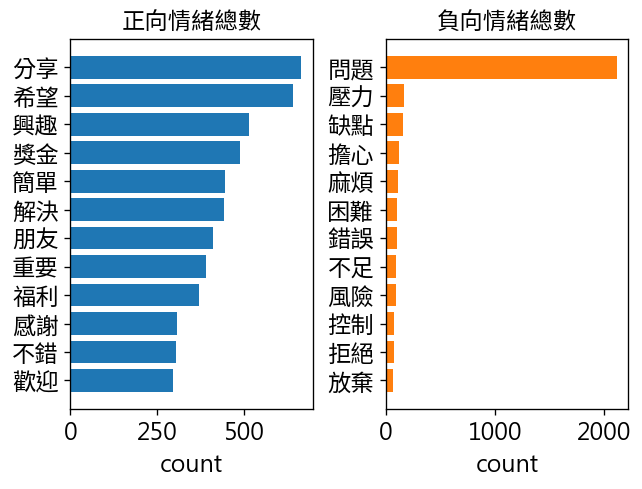

In [51]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()

word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(12).sort_values(["size"], ascending=True)
neg = word_of_neg.head(12).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

plt.subplots_adjust(wspace=0.3) 

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

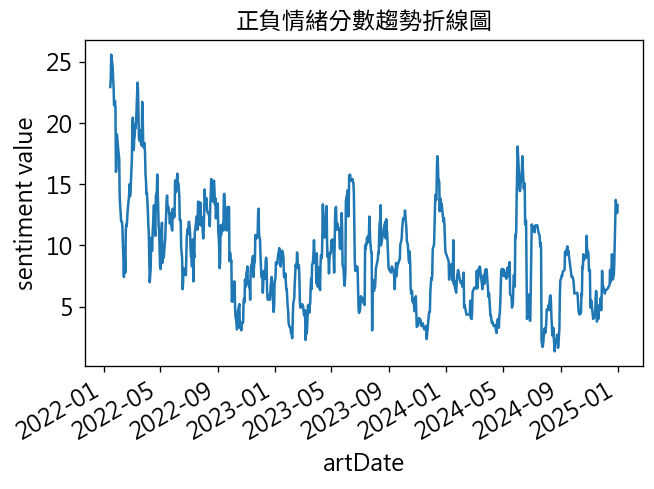

In [52]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.8 文字雲

2022-01 ~2022-06 在情緒分數趨勢圖上顯示比較高的分數，我們用文字雲來看一下這段時間出現了什麼關鍵字

In [53]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
3  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   

              artTitle                                         artContent  \
0  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
2  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
3  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
4  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   

  word sentiments sentiment_class  
0  一兩個        NaN              正向  
1   剛剛        NaN              正向  
2   工作        NaN              正向  
3   有個        NaN              正向  
4   心得        NaN              正向

In [54]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
3  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  Re:[請益]刷leetcode找工作   

      artDate                                         artContent     sentence  \
0  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...  一兩個月前剛剛找完工作   
1  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...         有個心得   
2  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...         我覺得啦   
3  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...  用Leetcode面試   
4  2022-01-01  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...       就只是個媒介   

  sentiment_class  
0              正向  
1              正向  
2              正向  
3              正向  
4              正向

In [55]:
date = "2022-01-01"
end_date = "2022-06-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "正向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head(10)

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
2  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
3  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
4  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
5  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
6  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
7  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
8  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   
9  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...  2022-01-01   

              artTitle                                         artContent  \
0  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
2  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
3  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
4  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
5  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
6  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
7  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
8  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
9  Re:[請益]刷leetcode找工作  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   

       word sentiments sentiment_class  
0       一兩個        NaN              正向  
1        剛剛        NaN              正向  
2        工作        NaN              正向  
3        有個        NaN              正向  
4        心得        NaN              正向  
5  Leetcode        NaN              正向  
6        面試        NaN              正向  
7        媒介        NaN              正向  
8        題目        NaN              正向  
9        通常        NaN              正向

In [56]:
date = "2022-01-01"
end_date = "2022-06-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "正向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

word  size
7493    工作   975
5571    公司   958
6495    問題   518
13151   開發   511
13396   面試   419
11122   經驗   417
9070    時間   405
7513   工程師   365
6649    團隊   330
10496   目前   311

(-0.5, 1599.5, 799.5, -0.5)

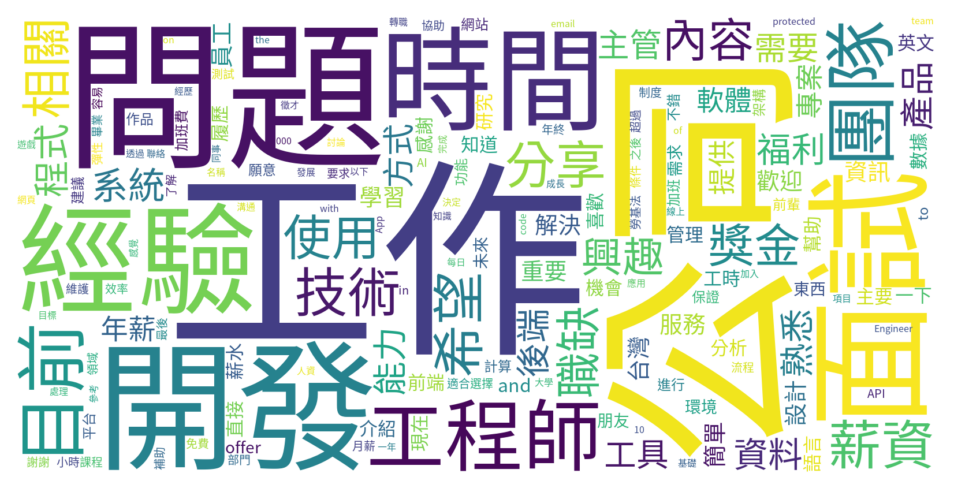

In [57]:
# wordcloud 的 input 是 dictionary
font_path = "SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 1599.5, 799.5, -0.5)

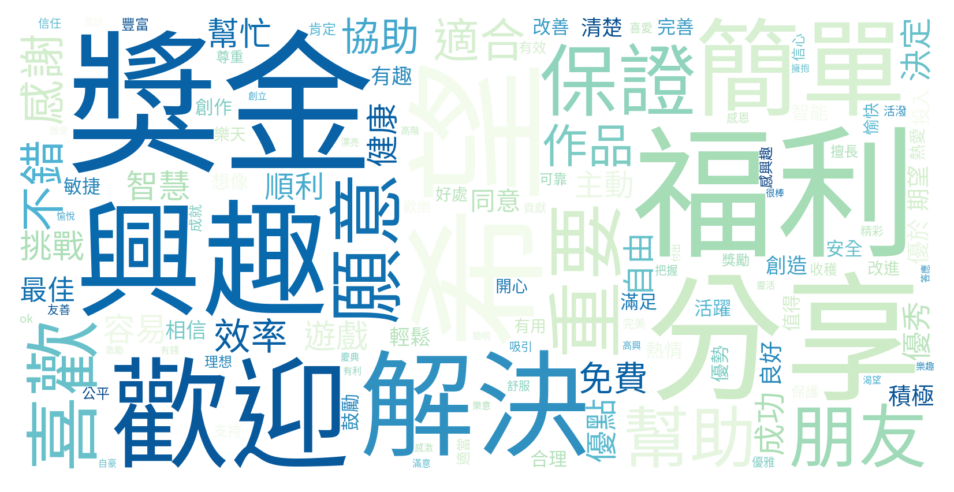

In [58]:
date = "2022-01-01"
end_date = "2022-06-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "正向")  & ( # 正面文章
    ptt_liwc_df_revise['artContent'].str.contains('公司')) & ( # 內文包含公司
    ptt_liwc_df_revise["sentiments"] == "positive") # 正面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

In [59]:
date = "2022-01-01"
end_date = "2022-06-01"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "正向") & (
    sent_df['artContent'].str.contains('公司')) & (
    sent_df['sentence'].str.contains('福利')) # 包含「福利」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['artTitle', 'sentence', 'sentiment_class']]

artTitle                   sentence sentiment_class
311    開店123徵PHP工程師(50k~80k/1Y)                   開店123以成為              正向
312    開店123徵PHP工程師(50k~80k/1Y)                   電子商務專家自豪              正向
313    開店123徵PHP工程師(50k~80k/1Y)        在這邊可以學到電子商務的各種知識與技能              正向
314    開店123徵PHP工程師(50k~80k/1Y)                   我們期待你的加入              正向
315    開店123徵PHP工程師(50k~80k/1Y)                   同創造出最佳價值              正向
...                         ...                        ...             ...
23699       [徵才]高雄仁武台塑雲端組徵前端工程師  長庚醫院就醫優待自費項目折扣員工本人及其子女為6折              正向
23700       [徵才]高雄仁武台塑雲端組徵前端工程師                     其父母為7折              正向
23701       [徵才]高雄仁武台塑雲端組徵前端工程師       婚喪賀奠禮品金子女教育獎學金員工購股獎勵              正向
23702       [徵才]高雄仁武台塑雲端組徵前端工程師    完善的員工餐廳宿舍運動場館桌球羽球籃球和健身房              正向
23703       [徵才]高雄仁武台塑雲端組徵前端工程師                       應徵方式              正向

[1071 rows x 3 columns]

可見大家很注重也很滿意當時的福利和獎金

## 4 CKIP自然語言處理


### 4.1 CKIP安裝

In [86]:
data_utils.download_data_gdown("./")  # 下載ckip model

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=538bd5ff-cf69-4c93-bb6b-85e963118f22
To: c:\大四下\社群媒體分析\第一次作業\data.zip
100%|██████████| 1.88G/1.88G [14:56<00:00, 2.09MB/s]


### 4.2 利用CKIP進行自然語言處理

In [60]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Python311\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Python311\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Python311\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [61]:
## 讀取文章
df = pd.read_csv('merge.csv')
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1640971317.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1641017622.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1641020395.A...   

               artTitle              artDate     artPoster artCatagory  \
0   Re:[請益]刷leetcode找工作  2022-01-01 01:21:54     Ericz7000    Soft_Job   
1  [請益]請問面試作品可以放gitlab嗎  2022-01-01 14:13:40      s9503669    Soft_Job   
2   Re:[請益]刷leetcode找工作  2022-01-01 14:59:51  FlowerKnight    Soft_Job   

                                          artContent  \
0  哥\n\n一兩個月前剛剛找完工作\n\n有個心得\n\n我覺得啦\n\n用Leetcode面...   
1  不好意思，因為不是很確定所以想問一下，\n\n\n通常很多職缺都會要求求職者給 github...   
2  在下的觀察\n\n找工作分成履歷跟面試 履歷關過了才有面試\n\n大概會看這些\n\n* 資...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "chocopie", "...     216.9.110.8   
1  [{"cmtStatus": "→", "cmtPoster": "gasbomb", "c...    1.200.71.248   
2  [{"cmtStatus": "推", "cmtPoster": "SouthRa", "c...  125.228.129.84   

          insertedDate dataSource  
0  2022-01-02 01:14:39        ptt  
1  2022-01-02 01:14:39        ptt  
2  2022-01-02 01:14:39        ptt

In [62]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [63]:
# 自定義辭典
with open('user_dict.txt', encoding='utf-8') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(4, {'自我介紹': 500.0, '很有問題': 500.0})]


In [64]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [65]:
# 看看 tmp 和 flat_list 有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['哥'], ['兩個月前剛剛找完工作'], ['有個心得'], ['我覺得啦'], ['用面試']]
['哥', '兩個月前剛剛找完工作', '有個心得', '我覺得啦', '用面試']


In [66]:
#輸出table
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 1375.305452823639


In [67]:
pos_table.head() # word pos 列表

system_id word  pos
0          1    哥   Na
1          1    兩  Neu
2          1    個   Nf
3          1    月   Na
4          1    前   Ng

In [68]:
entity_table.head() # word entity 列表

system_id  word     ner
0          1  兩個月前    DATE
1          1   練練口  PERSON
2          1   麥肯錫     ORG
3          3    台北     GPE
4          3    新竹     GPE

In [69]:
sentence_table.head()

system_id    sentence
0          1           哥
1          1  兩個月前剛剛找完工作
2          1        有個心得
3          1        我覺得啦
4          1         用面試

In [70]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1023篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 967篇有抓到ner

total posts numbers: 1023
posts have NER: 967


In [71]:
# 將文章存成csv
pos_table.to_csv('pos_table_softjob.csv', index = False)
entity_table.to_csv('entity_table_softjob.csv', index = False)
sentence_table.to_csv('sentence_table_softjob.csv', index = False)

### 4.3 探索分析 - NER

In [72]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("pos_table_softjob.csv") 
entity_table = pd.read_csv("entity_table_softjob.csv") 
sentence_table = pd.read_csv("sentence_table_softjob.csv") 

In [73]:
entity_table['ner'].unique()

array(['DATE', 'PERSON', 'ORG', 'GPE', 'CARDINAL', 'NORP', 'LANGUAGE',
       'FAC', 'TIME', 'LAW', 'LOC', 'ORDINAL', 'MONEY', 'EVENT',
       'QUANTITY', 'PERCENT', 'PRODUCT', 'WORK_OF_ART'], dtype=object)

In [74]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

ner  count
1       DATE   3851
4        GPE   3265
0   CARDINAL   2757
11       ORG   2166
13    PERSON   1174
5   LANGUAGE    882
10   ORDINAL    882
16      TIME    844
9       NORP    409
7        LOC    349

Text(0.5, 0, 'Frequency')

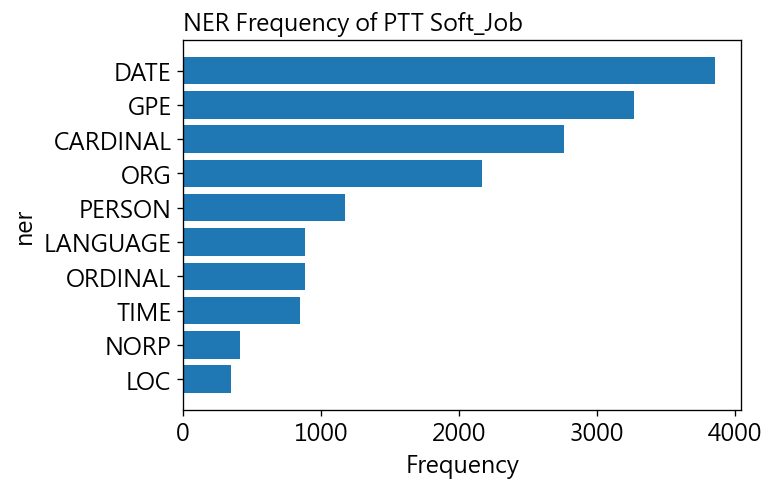

In [76]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(6, 4))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Soft_Job',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

想知道有哪些組織 可能是有軟體工作且熱門的

Text(0.5, 0, 'Word Frequency')

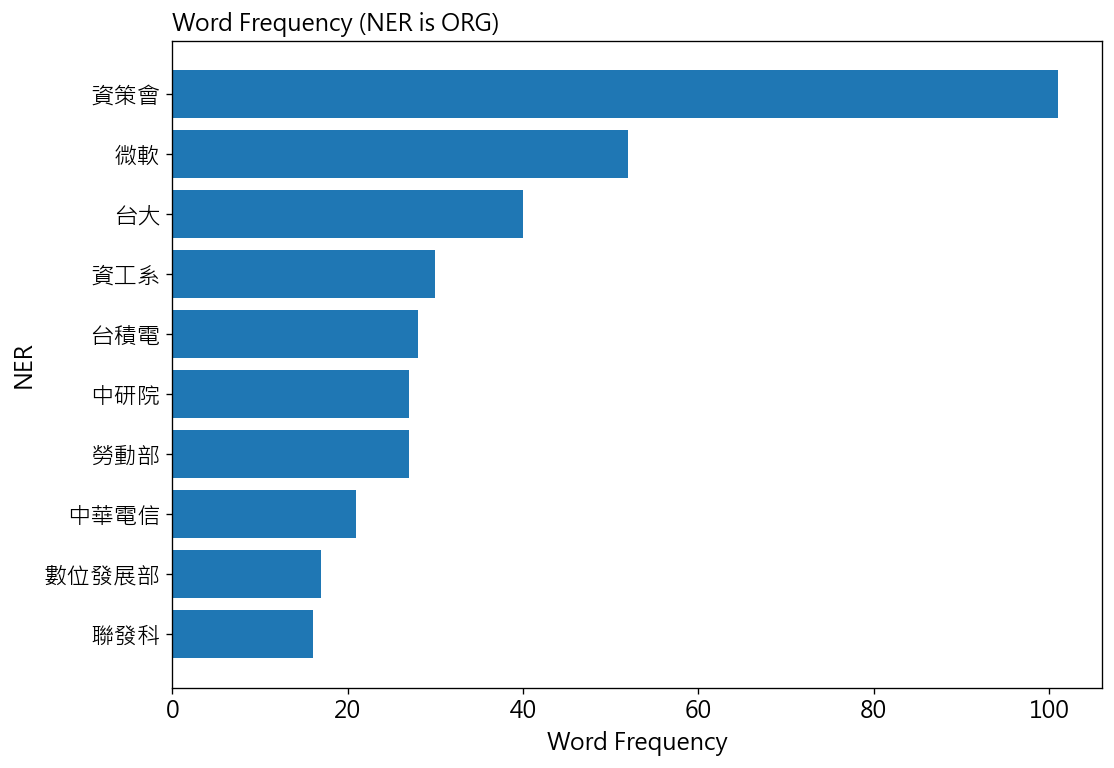

In [80]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以看到有很多資策會、微軟的相關文章，或是學歷相關的例如台大、資工系

### 了解對於語言的需求

Text(0.5, 0, 'Word Frequency')

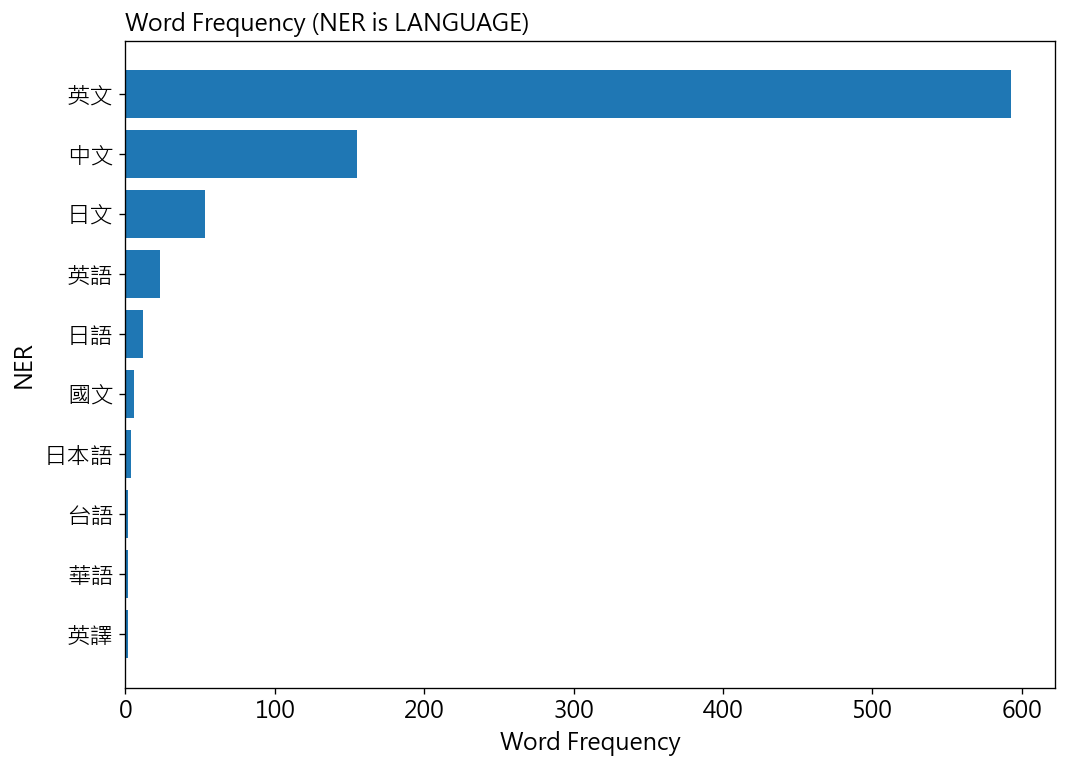

In [81]:
# 篩選ner為LANGUAGE的資料
l_noun = ["LANGUAGE"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is LANGUAGE)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以發現軟體工作非常多人討論英文！而其他如日語也是有討論度的

下面找出「英文」相關文章，與後續情緒分析一起做探索

In [82]:
keyword_list = ['英文']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

英文：279篇相關貼文


system_id                                             artUrl  \
4           5  https://www.ptt.cc/bbs/Soft_Job/M.1641095795.A...   
7           8  https://www.ptt.cc/bbs/Soft_Job/M.1641217344.A...   
28         29  https://www.ptt.cc/bbs/Soft_Job/M.1641827702.A...   

                         artTitle              artDate     artPoster  \
4   Re:[請益]以java作為技能的最低入行門檻(更新回應)  2022-01-02 11:56:32         qrtt1   
7                  [請益]Offer/現職請益  2022-01-03 21:42:21  NightDream08   
28                [心得]年薪破百萬的前端工程師  2022-01-10 23:15:01  tecofilmlove   

   artCatagory                                         artContent  \
4     Soft_Job  :\n:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n[---]\n\n  其實...   
7     Soft_Job  (非本人，純代PO)\n\n各位好，小弟約4-5年iOS經驗\n最近剛取得一份新的offer...   
28    Soft_Job  冏冏\nhttps://www.facebook.com/yue526828\nhttps:...   

                                           artComment           e_ip  \
4   [{"cmtStatus": "推", "cmtPoster": "alberty0519"...  36.227.43.158   
7   [{"cmtStatus": "→", "cmtPoster": "pttworld", "...    36.229.7.28   
28  [{"cmtStatus": "推", "cmtPoster": "vi000246", "...            NaN   

           insertedDate dataSource  
4   2022-01-03 01:11:59        ptt  
7   2022-01-04 01:17:07        ptt  
28  2022-01-11 01:21:36        ptt

## 4.4 探索分析 - POS

In [83]:
pos_table['pos'].unique()

array(['Na', 'Neu', 'Nf', 'Ng', 'D', 'VC', 'V_2', 'Nh', 'VK', 'T', 'P',
       'Da', 'SHI', 'VH', 'COMMACATEGORY', 'VB', 'A', 'VE', 'DE', 'Dfa',
       'Cbb', 'Ncd', 'VA', 'Nc', 'Nb', 'Cab', 'Neqa', 'VF', 'VD', 'VJ',
       'Nd', 'VG', 'Nv', 'Di', 'Caa', 'FW', 'Nep', 'Nes', 'VL', 'VI',
       'VCL', 'VHC', 'Dk', 'Dfb', 'DM', 'Cba', 'Neqb', 'VAC',
       'PARENTHESISCATEGORY', 'I', 'COLONCATEGORY', 'PERIODCATEGORY',
       'SEMICOLONCATEGORY', 'ETCCATEGORY'], dtype=object)

In [86]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

pos   count
16   Na  136618
5     D   79238
37   VC   60160
43   VH   37954
6    DE   32866
28   Nh   25347
30    P   24402
18   Nc   19333
40   VE   19045
26   Nf   18950
4   Cbb   16497
32  SHI   14950

C:\Users\angel\AppData\Local\Temp\ipykernel_40248\2478466374.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


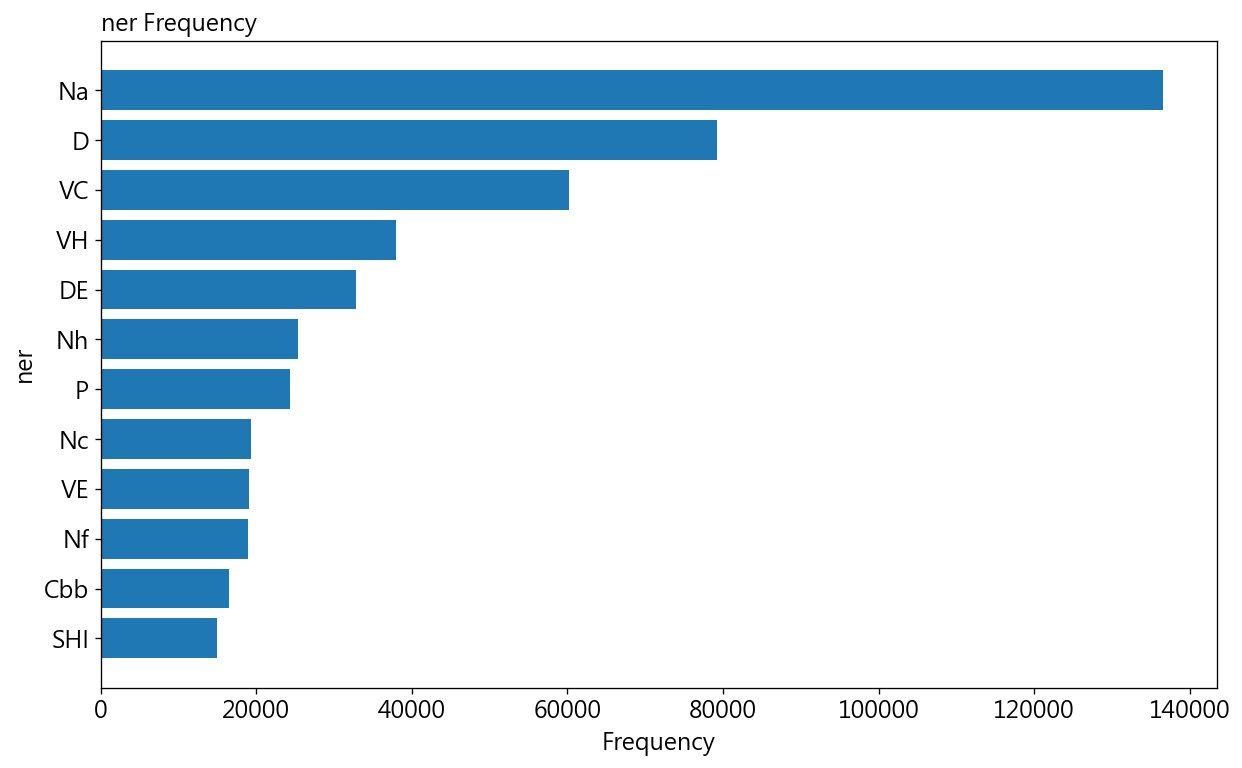

In [85]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)

In [87]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

word  count
595   每日    127
963   資安     97
427   微軟     59
216    周     41
252   國泰     36
930  許志全     34
188  台積電     34
969   資通     29
937  詹宏志     26
782   網家     25

C:\Users\angel\AppData\Local\Temp\ipykernel_40248\488784228.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


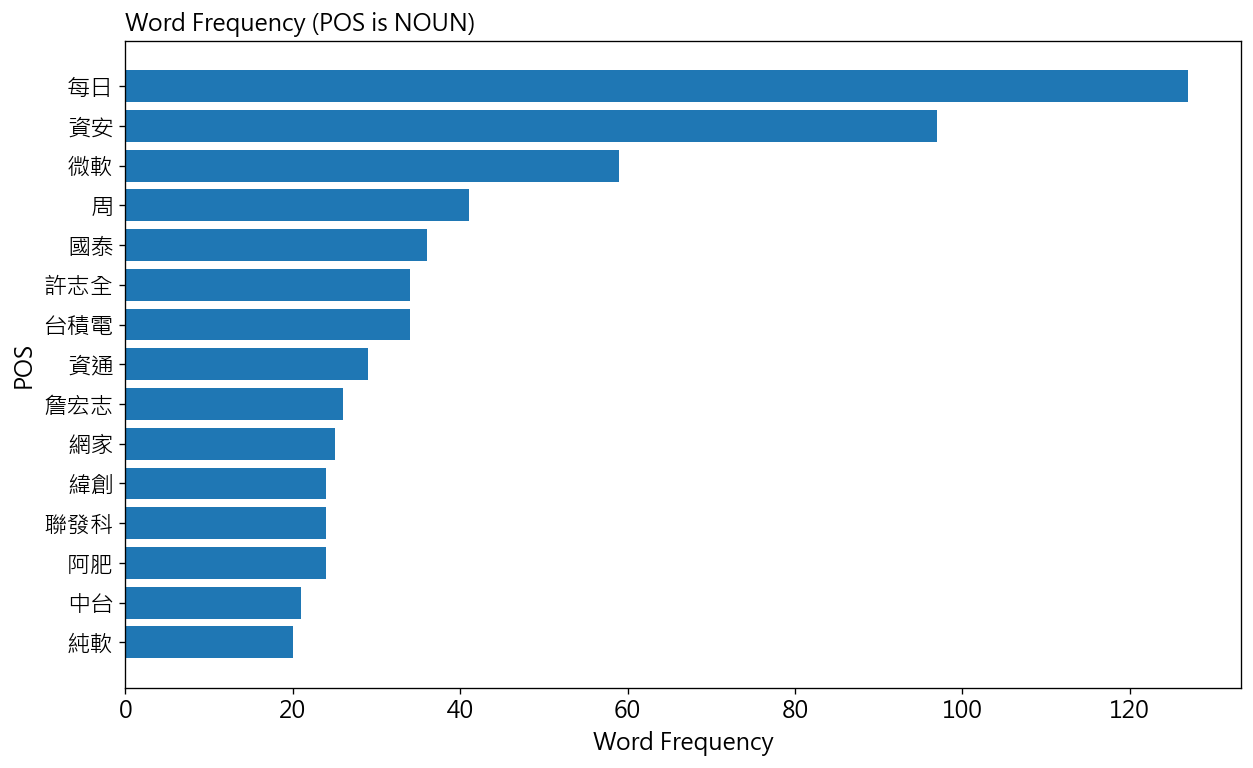

In [88]:
# 設定中文字形
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以發現「資安」是很常被討論的議題，而多家公司如微軟、台積電、緯創都有許多討論

### 涉及到的動詞

In [89]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

word  count
3579   面試   2392
3484   開發   1998
142    使用   1332
819    學習    781
1918   服務    547
3311   進行    498
2761   處理    472
2876   解決    441
2103   測試    423
3315   遇到    403
3350   選擇    395
829    完成    394
1385   拿到    375
2482   管理    366
2291   發展    362

C:\Users\angel\AppData\Local\Temp\ipykernel_40248\29217454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


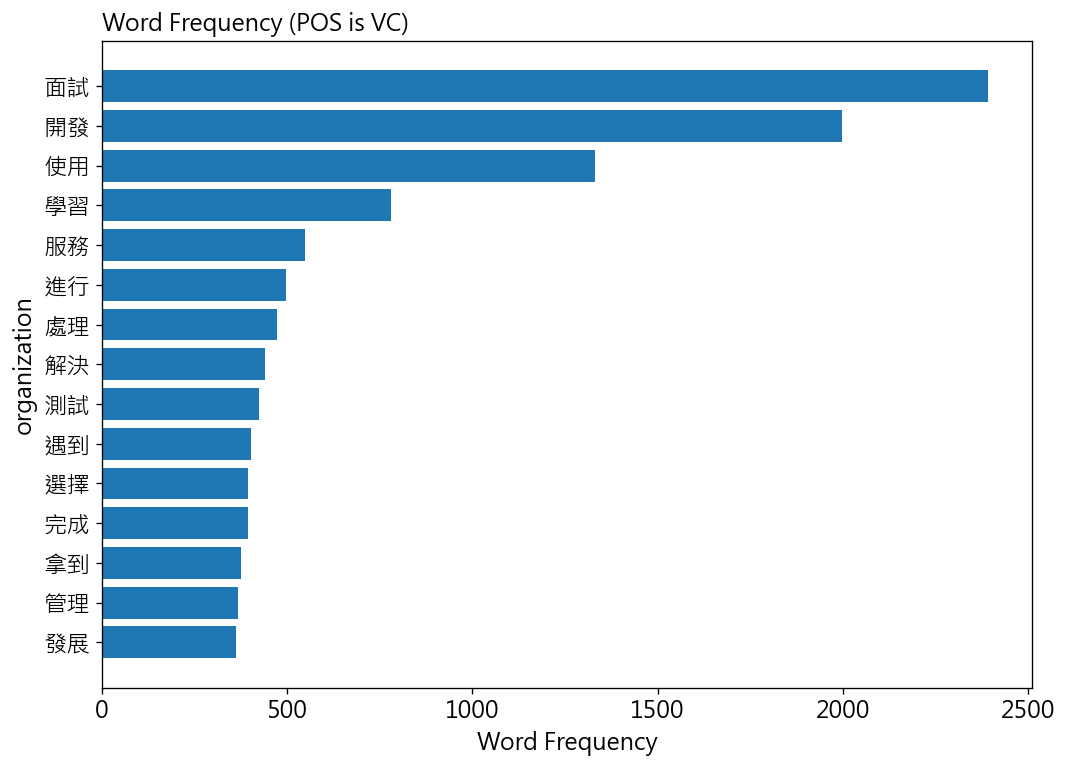

In [90]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可見「開發」、「使用」、「學習」可能是面試時注重的問題或大家常討論的問題

## 5. 利用SnowNLP進行情緒分析

In [91]:
sentence_table = pd.read_csv("sentence_table_softjob.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

system_id             sentence              artDate dataSource
27          2   不好意思，因為不是很確定所以想問下，  2023-01-01 15:48:11        ptt
28          2  通常很多職缺都會要求求職者給作品連結，  2023-01-01 15:48:11        ptt
29          2   但我沒在使用，另方面我想用作完整的，  2023-01-01 15:48:11        ptt

In [92]:
from snownlp import SnowNLP
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

system_id             sentence              artDate dataSource  \
27          2   不好意思，因為不是很確定所以想問下，  2023-01-01 15:48:11        ptt   
28          2  通常很多職缺都會要求求職者給作品連結，  2023-01-01 15:48:11        ptt   
29          2   但我沒在使用，另方面我想用作完整的，  2023-01-01 15:48:11        ptt   

    sentimentValue  
27        0.050298  
28        0.052745  
29        0.640636

In [95]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    3.051500e+04
mean     3.678077e-01
std      3.173842e-01
min      2.604980e-09
25%      5.918891e-02
50%      3.026687e-01
75%      6.019906e-01
max      9.999985e-01
Name: sentimentValue, dtype: float64

<Axes: >

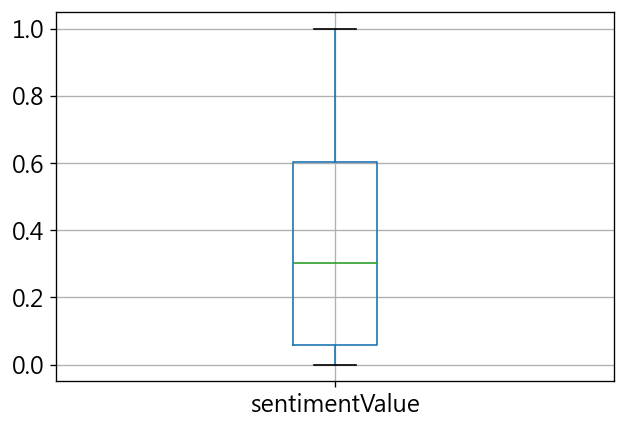

In [94]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

資料呈現偏向負面情緒較多，可能因為面試不理想所以到網路上抱怨。

In [96]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

artDate  sentimentValue
0   2022-01        0.393139
1   2022-02        0.394422
2   2022-03        0.377540
3   2022-04        0.372453
4   2022-05        0.360045
5   2022-06        0.360230
6   2022-07        0.332082
7   2022-08        0.382267
8   2022-09        0.391974
9   2022-10        0.306375
10  2022-11        0.353092
11  2022-12        0.389618
12  2023-01        0.364033
13  2023-02        0.398801
14  2023-03        0.376203
15  2023-04        0.370063
16  2023-05        0.363007
17  2023-06        0.358489
18  2023-07        0.363514
19  2023-08        0.378456
20  2023-09        0.372540
21  2023-10        0.393524
22  2023-11        0.369026
23  2023-12        0.383771
24  2024-01        0.390496
25  2024-02        0.384806
26  2024-03        0.356435
27  2024-04        0.340654
28  2024-05        0.334689
29  2024-06        0.375232
30  2024-07        0.364790
31  2024-08        0.375880
32  2024-09        0.338805
33  2024-10        0.359034
34  2024-11        0.371027
35  2024-12        0.352368

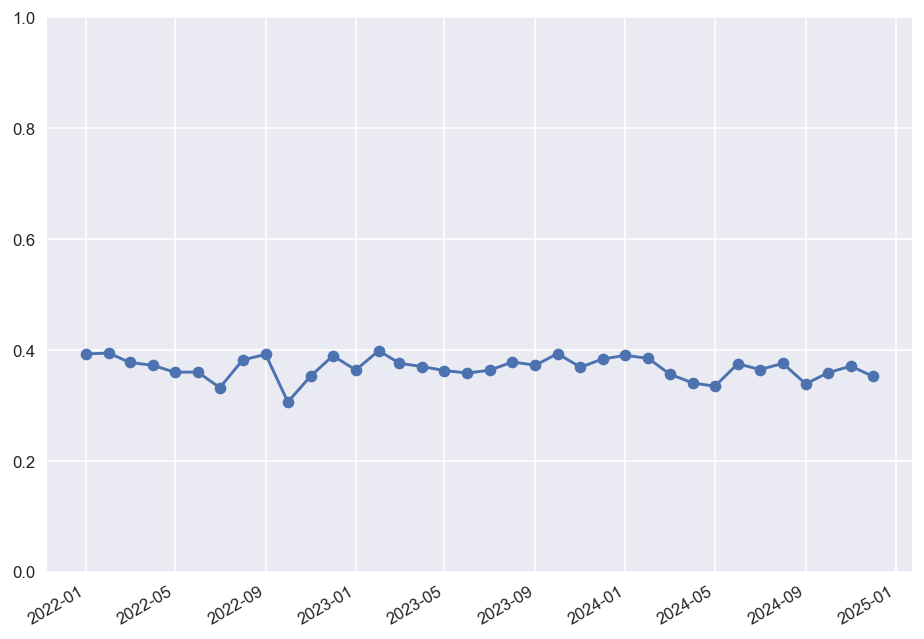

In [97]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

平均皆在0.4左右 較為中性

挑出最低的2022-10來進階分析詞彙

In [98]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2022-10']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.2]

filter_sentiment.head()

system_id                             sentence  artDate dataSource  \
28094        842             你是站在地上靠自己的身高跟站在巨人肩膀上的在競爭  2022-10        ptt   
28096        842   而成的情況當你需要自己造輪子的時候，你如果不是已經用過各式各樣的輪子  2022-10        ptt   
28099        842           你看過最難的程式碼大部分是你自己寫出來的，天花板很低  2022-10        ptt   
28104        842  自學不是壞事，但寫程式如果目標是要能夠參與團隊做商業開發，趕快找個可以  2022-10        ptt   
28105        842              接觸大量範例可以模仿可以參與團隊的工作會比較好  2022-10        ptt   

       sentimentValue  
28094        0.086967  
28096        0.014258  
28099        0.121528  
28104        0.006934  
28105        0.003456

In [102]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

system_id  sentimentValue word
0        842        0.086967   從來
1        842        0.086967    都
2        842        0.086967   不用
3        842        0.086967   框架
4        842        0.086967    跟

In [103]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

繪製正面詞彙文字雲

In [104]:
# 自定停用字
with open('stopwords.txt', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一']


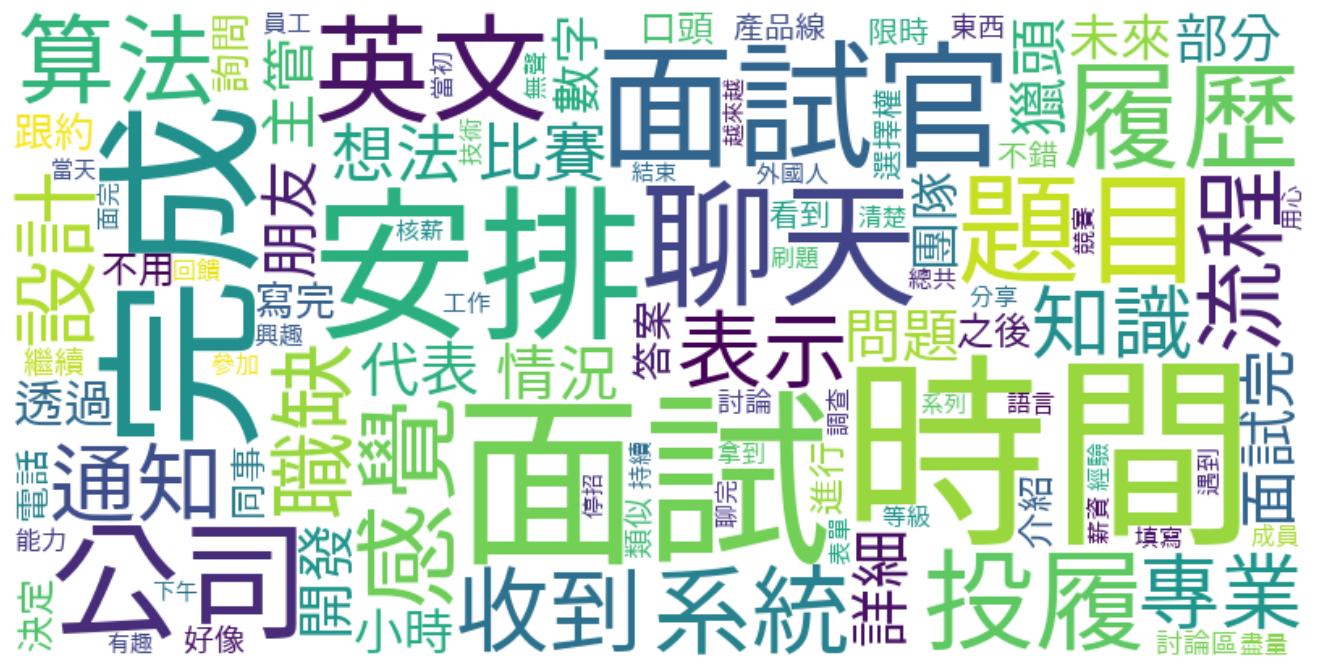

In [105]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(("需要", "to", "and", "最後", "現在", "直接", "因為", "大概", "目前", "知道", "還是", "沒有", "什麼", "這個", "時候", "一下", "真的", "開始", "我們", "一個", "這些", "可能"))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

時間、面試、面試官、安排，對尋找軟體工作有很多的討論度

# 6. 遇到的困難
+ 斷詞錯誤率高，手動更新耗時
+ 有些詞可能不是代表某一種情緒，需要額外印出並分析文本
+ Tarflow資料抓取不順利